# Fetal Health Classification.

## Step 1 : Import necessary libraries and warnings

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, precision_score, confusion_matrix, accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn import set_config
set_config(print_changed_only=False)
from xgboost import XGBClassifier
#from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/drive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

## Step 2 : Reading and Understanding the dataset.

In [ ]:
#reading in CSV's from a file path
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UAS DMK/fetal_health.csv')
# previewing the DataFrame
df.head()

In [ ]:
#  Displaying top 5 records from "fetal_health.csv" dataset.
df.head()

In [ ]:
# Displaying last 5 records from "fatal_health.csv" dataset.
df.tail()

In [ ]:
# Determining the shape of data.
df.shape

#### This dataset contains 2126 rows and 22 columns.

In [ ]:
# Describe the data.
df.describe(include = "all")

#### The above snippet gave the statistical/mathematical display of dataset.

In [ ]:
# Understanding the data by checking the datatype of each column.
df.info(verbose = True)

##### We have all columns data in "float64" format ie. all continues variables. So we dont have to worry about data type conversion.

## Step 3 : Data Cleaning.

##### Drop columns that are having high percentage of missing values. Check all the columns before dropping them and then impute values in columns which are important.

In [ ]:
# Define a function for getting missing values.

def getMissingValues(missingCutoff):
    missing = round(100*(df.isnull().sum()/df.shape[0]))
    print("There are {} features having more than {}% missing values".format(len(missing.loc[missing > missingCutoff]),missingCutoff))
    return missing.loc[missing > missingCutoff]

In [ ]:
# Call the missing values function by passing the threshold value.
getMissingValues(10)

This dataset dont have any missing values So, we dont have to impute values.

In [ ]:
# See the different values present in "fetal_health" variable.

df.fetal_health.value_counts()

#####Here we have three classes as :
#####1. Normal
#####2. Suspect
#####3. Pathological

## Step 4 : Exploratory Data Analysis (EDA)

Now we want to take the indepth look at dataset.
we will look at target variable and the relationship of other features with each other.

In [ ]:
# Lets check the distribution of target variable first.

sns.set_style("darkgrid")
plt.figure(figsize = (14, 6))
sns.countplot(df["fetal_health"], alpha = 1, palette = ["lightgreen", "orange", "red"])
plt.title("Fetal Health Classifications", fontsize = 20)
plt.ylabel("No of Patients")
plt.xlabel("Fetal Health Classes")
plt.show()

**Observation** - In this plot we have shown the distribution of samples that where classified as either (1) Normal, (2) Suspect, (3) Pathological.

Also there is a significant difference in the sample sizes.  we need to consider class imbalance in our modeling parameters.

In [ ]:
# Check histograms for all features.

df.hist(bins = 60,
          figsize = (20, 20))
plt.show()

In [ ]:
# Check the feature correlation.

corr = df.corr()
fig, ax = plt.subplots(figsize = (15, 6))
sns.heatmap(corr, annot = True, cmap="RdPu");

In [ ]:
# To examine the feature dependancy lets create a dataframe for predictor variables.

pred_df = df.drop("fetal_health", axis = 1)

In [ ]:
# Now lets plot a scatter plot between the target variable and predictor variables.

pd.plotting.scatter_matrix(pred_df, figsize = (50, 50));
plt.show()

**Observation** - In this plot of the EDA we checked individual features and their interactions with the target variable and other features.  

We were looking any irregularities, outliers and distributions, that we could use to create new features for better classification.  

There are some important features that are useful for our model. lets look into it.

In [ ]:
# Check value counts of "uterine_contractions" feature.

df.uterine_contractions.value_counts()

0.000    332
0.005    290
0.004    244
0.006    231
0.007    216
0.003    212
0.008    160
0.002    160
0.001    118
0.009     82
0.010     49
0.011     16
0.012     11
0.013      2
0.014      2
0.015      1
Name: uterine_contractions, dtype: int64

In [ ]:
# Now Check value counts of "abnormal_short_term_variability" feature.

df.abnormal_short_term_variability.value_counts()

60.0    62
58.0    61
65.0    60
63.0    58
64.0    58
        ..
14.0     4
86.0     4
12.0     2
82.0     2
87.0     1
Name: abnormal_short_term_variability, Length: 75, dtype: int64

**Observation**- We have to take a closer look at the histogram features.  These features where values taken from the histogram of the baseline fetal heart rate and the frequency of changes over time.

These distribution of FHR changes over time are the same metrics that physicians use for their visual analysis of the CTG.  

Our initial thought was that these histogram values would be the key variables in determining fetal health prediction of class.

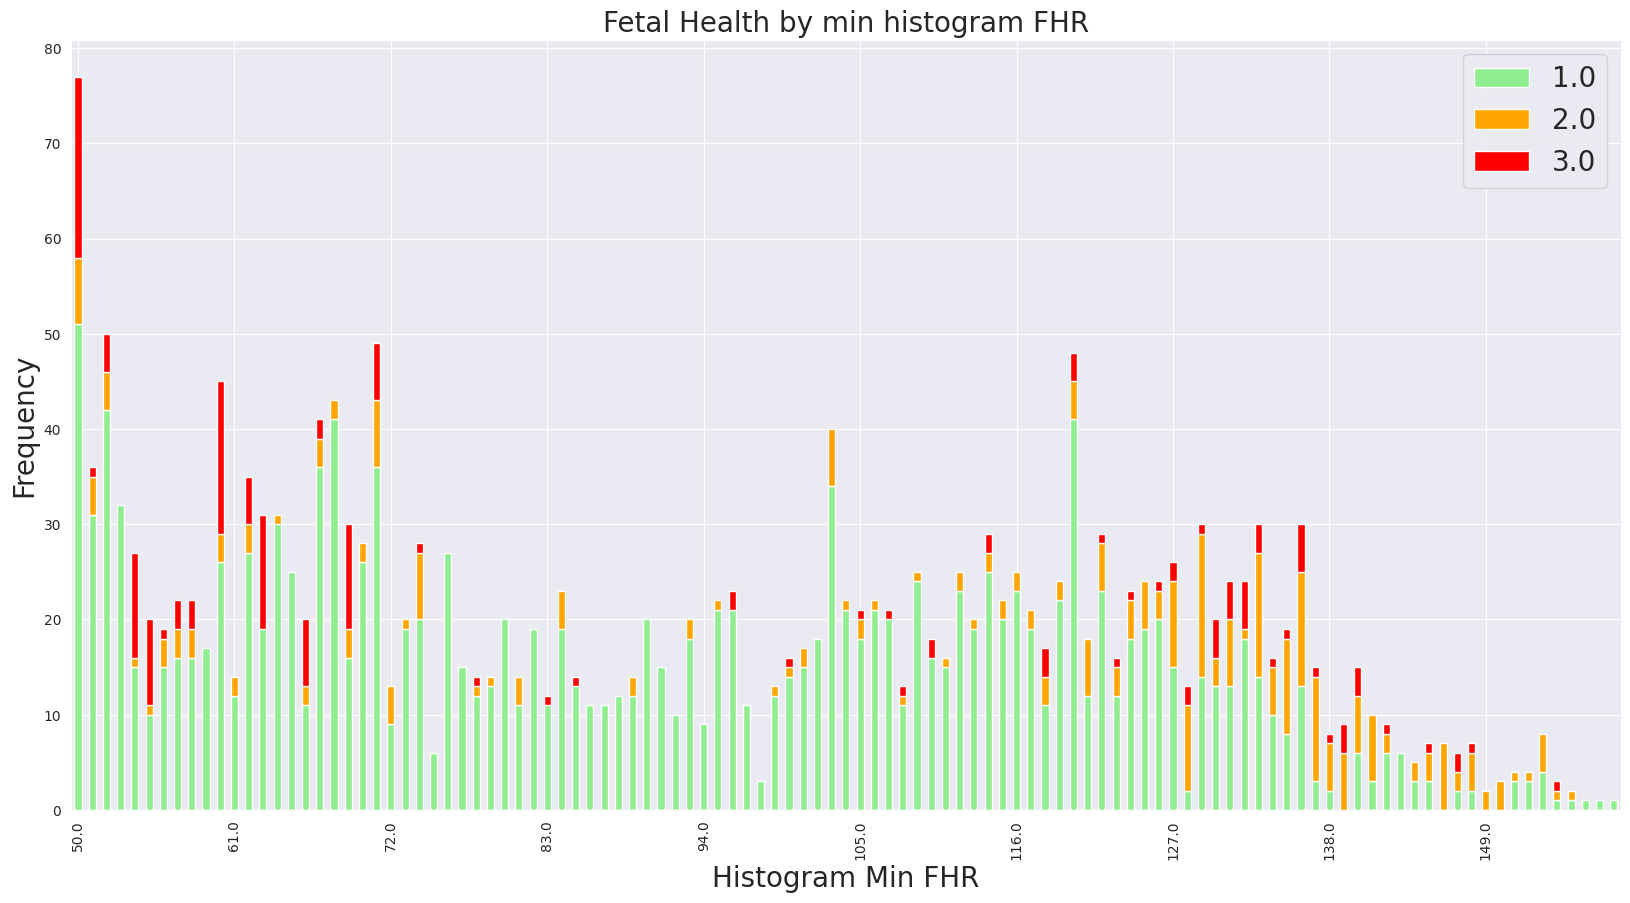

In [ ]:
# Plot histogram showing the distrubition values of minimum FHR by the classes.

histogram_min = df.groupby(["histogram_min", "fetal_health"]).histogram_min.count().unstack()
pl = histogram_min.plot(kind = 'bar',
                   stacked = True,
                   color = ["lightgreen", "orange", "red"],
                   figsize = (20,10))
pl.set_xlabel("Histogram Min FHR", fontsize = 20)
pl.locator_params(axis = "x", nbins = 10)
pl.legend(fontsize = 20)
pl.set_ylabel("Frequency", fontsize = 20)
pl.set_title("Fetal Health by min histogram FHR", fontsize = 20)
plt.show()

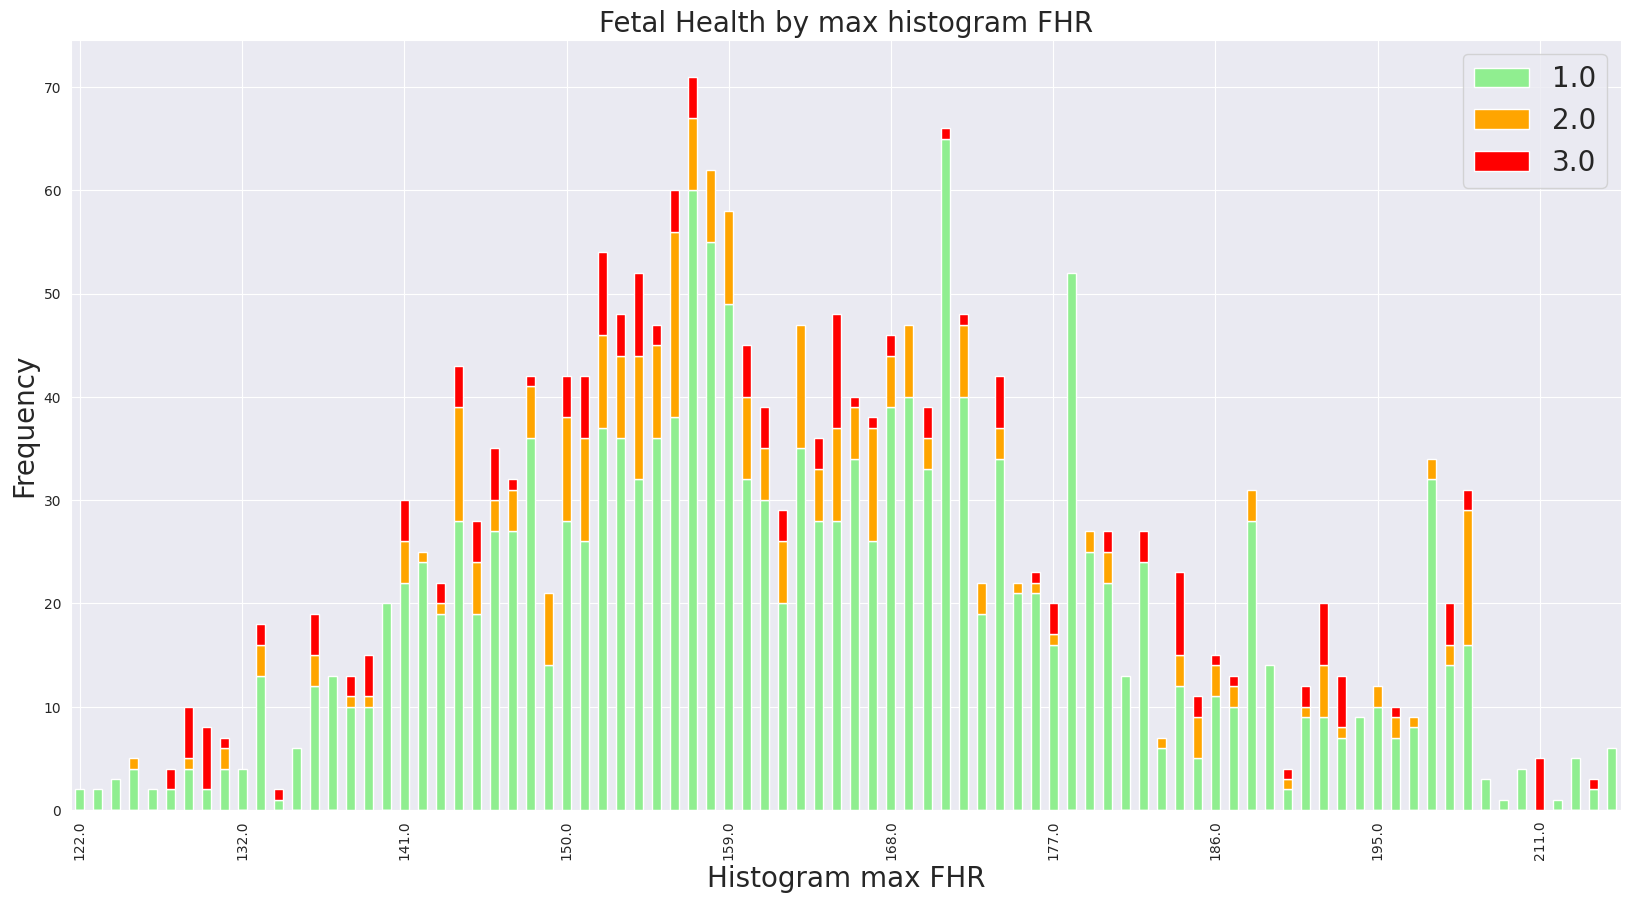

In [ ]:
# Plot histogram showing the histogram distribution values of maximum FHR by the classes.

histogram_min = df.groupby(["histogram_max", "fetal_health"]).histogram_max.count().unstack()
pl = histogram_min.plot(kind = "bar",
                        stacked = True,
                        color = ["lightgreen", "orange", "red"],
                        figsize = (20, 10))
pl.set_xlabel("Histogram max FHR", fontsize = 20)
pl.locator_params(axis = "x", nbins = 10)
pl.legend(fontsize = 20)
pl.set_ylabel("Frequency", fontsize = 20)
pl.set_title("Fetal Health by max histogram FHR", fontsize = 20)
plt.show()

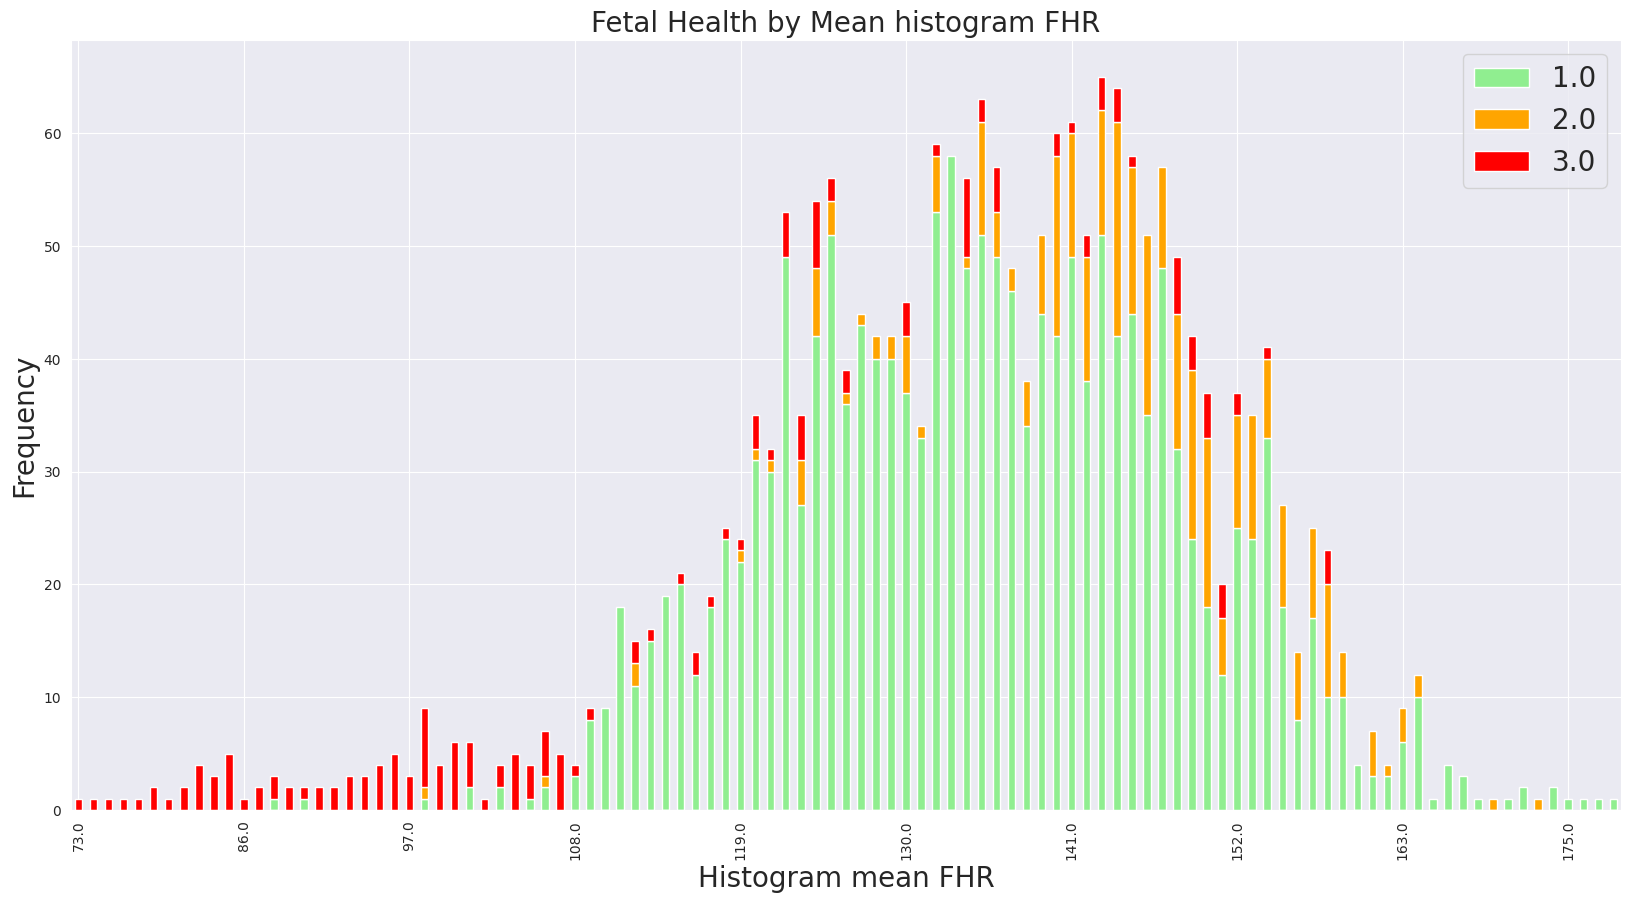

In [ ]:
# Plot histogram showing the histogram distribution values of average FHR by the classes.

histogram_min = df.groupby(["histogram_mean", "fetal_health"]).histogram_mean.count().unstack()
pl = histogram_min.plot(kind = "bar",
                        stacked = True,
                        color =["lightgreen", "orange", "red"],
                        figsize = (20, 10))
pl.set_xlabel("Histogram mean FHR", fontsize = 20)
pl.locator_params(axis = "x", nbins = 10)
pl.legend(fontsize = 20)
pl.set_ylabel("Frequency", fontsize = 20)
pl.set_title('Fetal Health by Mean histogram FHR', fontsize = 20)
plt.show()

**Observation** - In the above plots we can see the distribution of the two classes for the feature values.  

In the histogram min, you can see a clear section of the distribution only covered by our suspect and pathological class.

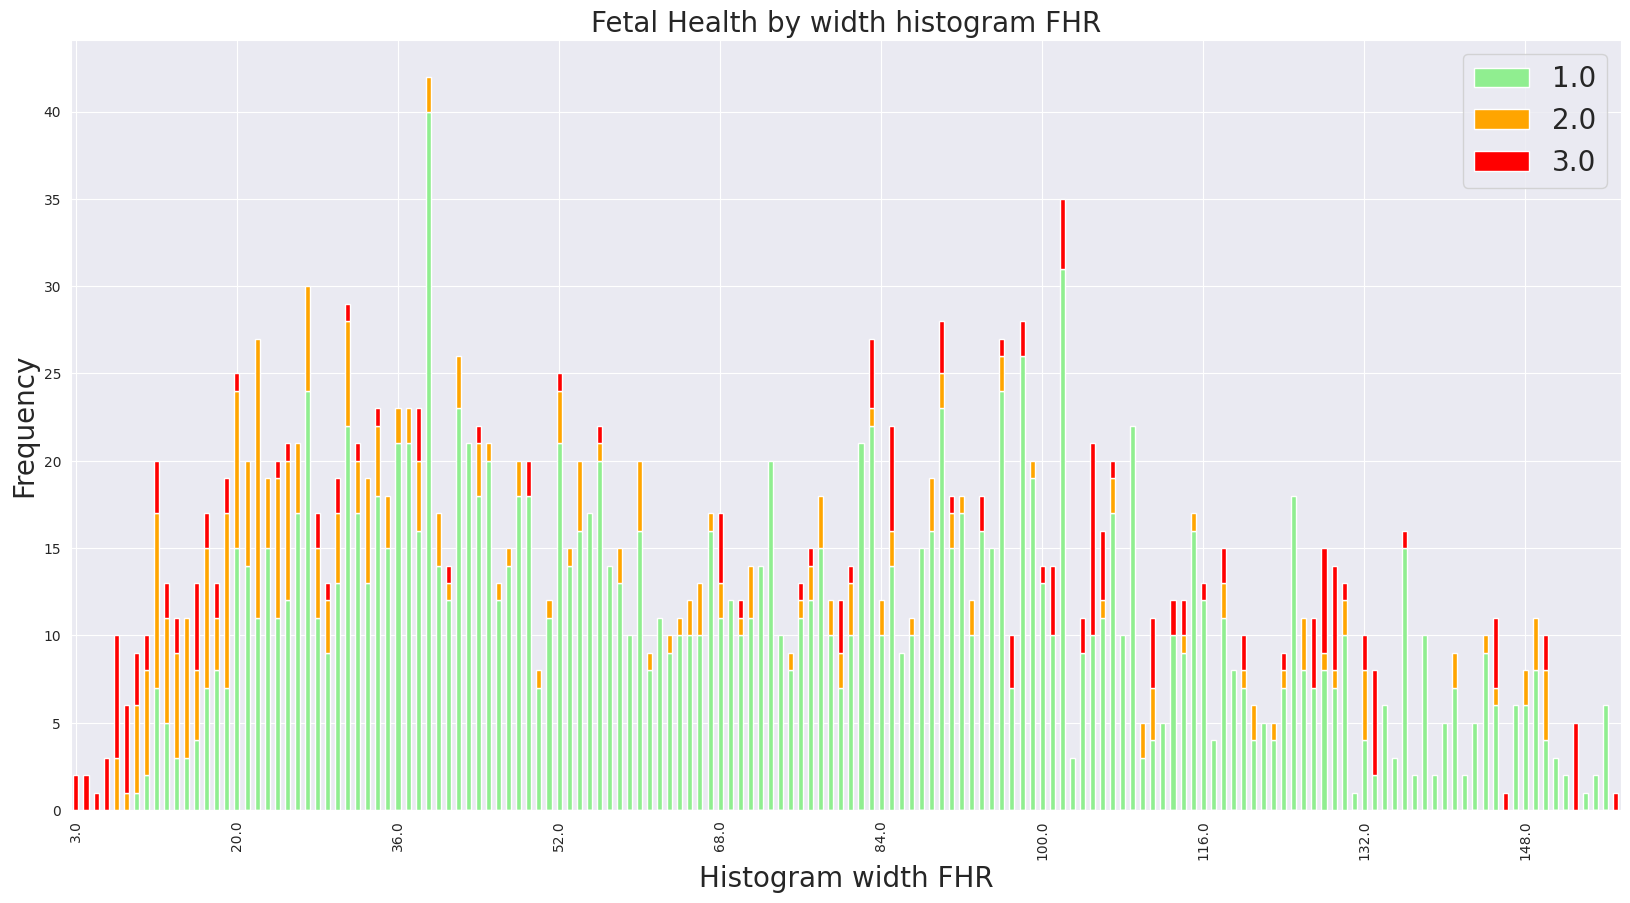

In [ ]:
# Plot histogram showing the histogram mean values of average FHR by the classes.

histogram_min = df.groupby(["histogram_width", "fetal_health"]).histogram_width.count().unstack()
pl = histogram_min.plot(kind = "bar",
                        stacked = True,
                        color =["lightgreen", "orange", "red"],
                        figsize = (20, 10))
pl.set_xlabel("Histogram width FHR", fontsize = 20)
pl.locator_params(axis = "x",nbins = 10)
pl.legend(fontsize = 20)
pl.set_ylabel("Frequency", fontsize = 20)
pl.set_title("Fetal Health by width histogram FHR", fontsize = 20)
plt.show()

**Observation** - Now we have to take a look at severe decelerations(Decelerations are temporary decreases in the fetal heart rate (FHR) during labor). We knew that any major changes of FHR when visually monitered results in immediate surgical intervention.  

The severe deceleration feature was almost synonymous with the suspect,pathological class, however of the 2126 instances in the dataset, there are only 7 instances of severe deceleration.  We suspect this is a key feature in classification, but there may not be enough data here to train the model due to class imbalance.  

we have to preform another analysis creating multiple classes of fetal distress, we hypothesis these extreme changes in fetal heart rate will play a role in classifying pathological fetal health.

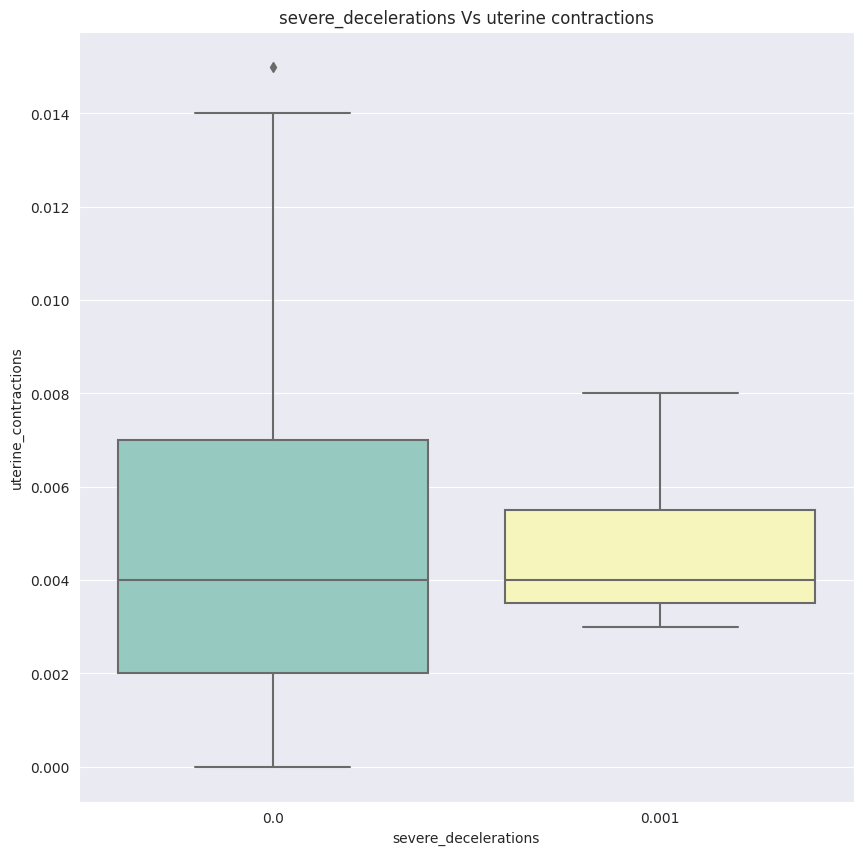

In [ ]:
# Plot boxplot of uterine_contractions over per sever deceleration of FHR.

plt.figure(figsize = (10, 10))
sns.boxplot(x = "severe_decelerations",
            y = "uterine_contractions",
            data = df,
            palette = "Set3").set_title("severe_decelerations Vs uterine contractions")
plt.show()

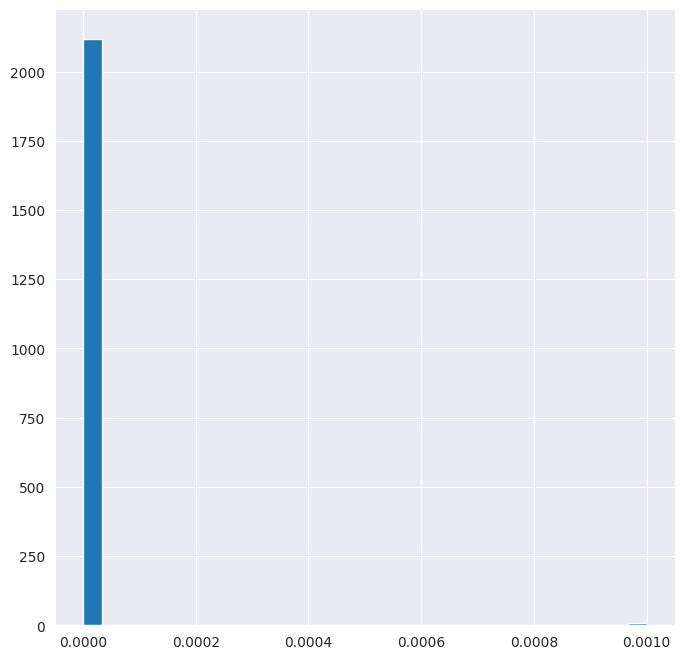

In [ ]:
# Now plot histogram for showing the distribution of severe_deceleration in the dataset.

df.severe_decelerations.hist(bins = 30,
                               figsize = (8, 8))
plt.show()

In [ ]:
# Lets check the value counts for severe_deceleration feature to verify.

df.severe_decelerations.value_counts()

0.000    2119
0.001       7
Name: severe_decelerations, dtype: int64

From 2126 instances in the dataset, there are only 7 instances of severe deceleration.

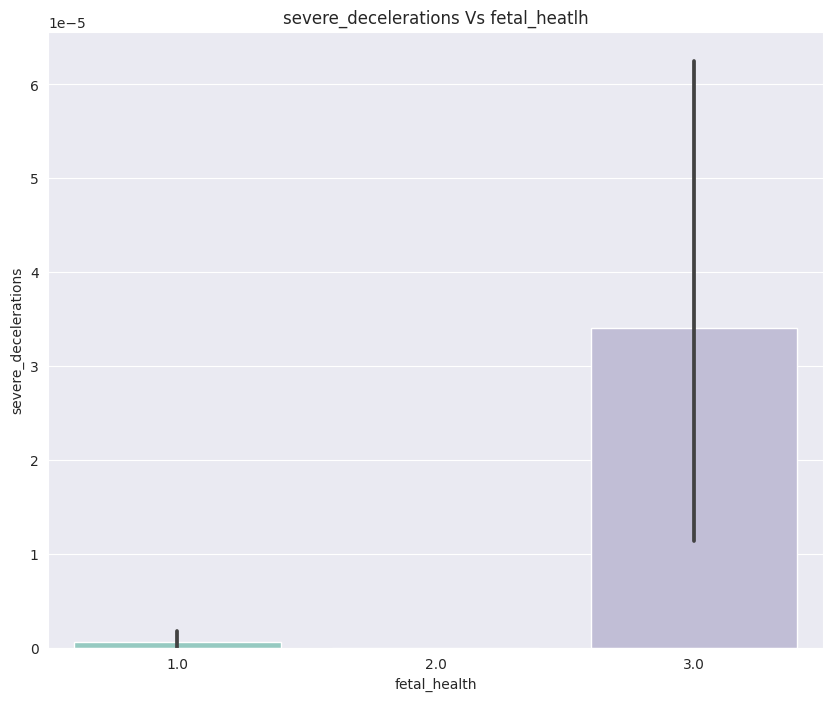

In [ ]:
# Now plot the boxplot between fetal_health and sever_deceleration.

plt.figure(figsize = (10, 8))
sns.barplot(x = "fetal_health",
            y = "severe_decelerations",
            data = df,
            palette = "Set3").set_title("severe_decelerations Vs fetal_heatlh")
plt.show()

## Step 5 : Feature Engineering.

Since the contraction is make to much importance in fetal health. we need to create a feature for it.

In [ ]:
# Create new column for contractions per min using "uterine_contractions" variable.

df["uterine_contraction_per_min"] = df["uterine_contractions"] * 60
df["uterine_contraction_per_min"].head()

0    0.00
1    0.36
2    0.48
3    0.48
4    0.48
Name: uterine_contraction_per_min, dtype: float64

Now lets see the "accelerations" feature.
Accelerations are short-term increases in fetal heart rate by at least 15 beats per minute (bpm) that last at least 15 seconds. These accelerations occur at different times throughout labor and delivery and are a sign that the fetus has an adequate supply of oxygen.

We need to analyse this feature also.

In [ ]:
# Check value counts of "acceleration" variable.

df.accelerations.value_counts()

0.000    894
0.003    161
0.002    160
0.001    143
0.004    117
0.006    112
0.005    110
0.008    103
0.007     91
0.009     60
0.010     50
0.011     36
0.012     24
0.013     22
0.014     20
0.015      9
0.016      7
0.017      4
0.018      2
0.019      1
Name: accelerations, dtype: int64

In [ ]:
# Get statistical data for "acceleration".

df.accelerations.describe(include = "catagory")

count    2126.000000
mean        0.003178
std         0.003866
min         0.000000
25%         0.000000
50%         0.002000
75%         0.006000
max         0.019000
Name: accelerations, dtype: float64

In [ ]:
# Lets bin the "acceleration" values using quantile.

df["quantile_wise_acceleration"] = pd.qcut(df["accelerations"],
                                     q = [0, .25, .75, 1],
                                     labels = False,
                                     duplicates = "drop")
df["quantile_wise_acceleration"].head()

0    0
1    0
2    0
3    0
4    1
Name: quantile_wise_acceleration, dtype: int64

In [ ]:
# Get value_counts from "quantile_wise_acceleration" feature

df.quantile_wise_acceleration.value_counts()

0    1697
1     429
Name: quantile_wise_acceleration, dtype: int64

We have another feature similar to acceleration which is "light_decelerations" which plays important role for defining the fetal health.

Lets analyze this feature

<Axes: >

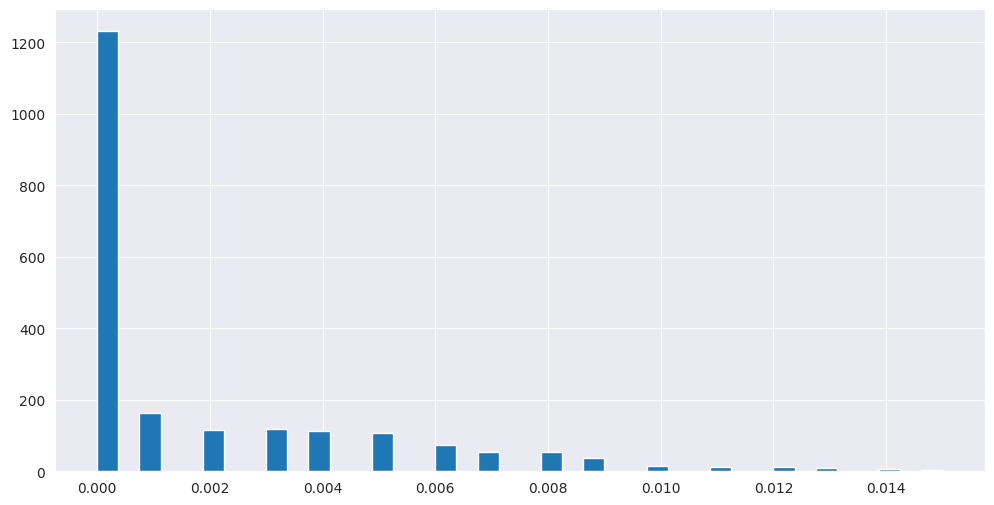

In [ ]:
# Plot graph showing distribution of FHR accelerations using "light_decelerations".

df.light_decelerations.hist(bins = 40,
                              figsize = (12, 6))

In [ ]:
# Get value counts for "light_decelerations".

df.light_decelerations.value_counts()

0.000    1231
0.001     163
0.003     118
0.002     115
0.004     114
0.005     107
0.006      74
0.008      55
0.007      54
0.009      37
0.010      15
0.011      13
0.012      12
0.013       8
0.014       7
0.015       3
Name: light_decelerations, dtype: int64

In [ ]:
# Lets bin the "light_decelerations" values using quantile.

df["quantile_light_decelerations"] = pd.qcut(df["light_decelerations"],
                                     q = 4,
                                     labels = False,
                                     duplicates = "drop")

In [ ]:
df["quantile_light_decelerations"].head()

0    0
1    0
2    0
3    0
4    0
Name: quantile_light_decelerations, dtype: int64

In [ ]:
# Get value counts for "light_decelerations".

df.quantile_light_decelerations.value_counts()

0    1627
1     499
Name: quantile_light_decelerations, dtype: int64

**Observation** In above code snippet we binned several continuous variable to create discrete variables.  

Our goal is to create catagories within the continuous features to observe if these catagories where class specific.  

Lets create another feature which combines the values of other important variable. Many on these features has zero values.

In [ ]:
# Create new column of all changes to the the baseline squared.

df["root_total_change"] = (df.accelerations +
                             df.fetal_movement +
                             df.uterine_contractions +
                             df.light_decelerations +
                             df.severe_decelerations +
                             df.prolongued_decelerations)**.5

df["root_total_change"].head()

0    0.000000
1    0.122474
2    0.118322
3    0.118322
4    0.122474
Name: root_total_change, dtype: float64

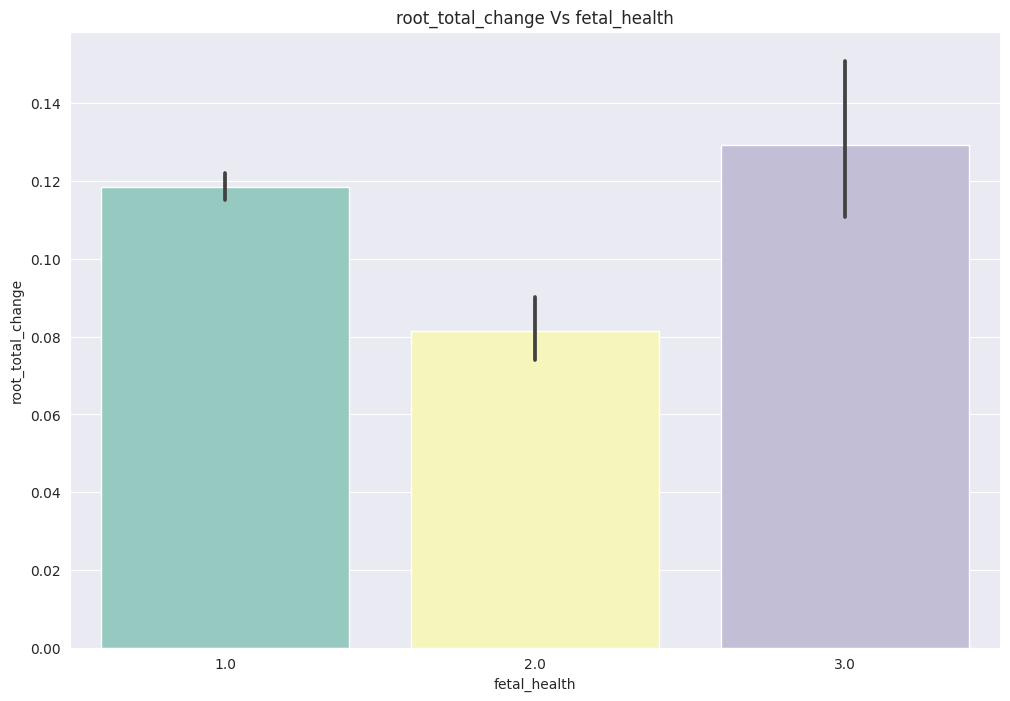

In [ ]:
# Lets plot a barplot of the root_total_change Vs fetal_health

plt.figure(figsize = (12, 8))

sns.barplot(x = "fetal_health",
            y = "root_total_change",
            data = df,
            palette = "Set3").set_title("root_total_change Vs fetal_health")
plt.show()

#### We need to create some dummy variables for sime features from dataset.

In [ ]:
df.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health', 'uterine_contraction_per_min',
       'quantile_wise_acceleration', 'quantile_light_decelerations',
       'root_total_change'],
      dtype='object')

In [ ]:
# Create dummy variables.

histogram_number_of_zeroes_dummie = pd.get_dummies(df.histogram_number_of_zeroes, prefix = "hist_zeros", drop_first = True)
histogram_tendency_dummie = pd.get_dummies(df.histogram_tendency,prefix = "hist_tendancy", drop_first = True)
severe_decelerations_dummie = pd.get_dummies(df.severe_decelerations,prefix = "sev_decel", drop_first = True)
quantile_wise_acceleration_dummie = pd.get_dummies(df.quantile_wise_acceleration, prefix = "quant_acc", drop_first = True)
quantile_light_decelerations_dummie = pd.get_dummies(df.quantile_light_decelerations, prefix = "quant_light_dec", drop_first = True)

In [ ]:
dummie_data = pd.concat([histogram_number_of_zeroes_dummie,
                         histogram_tendency_dummie,
                         severe_decelerations_dummie,
                         quantile_wise_acceleration_dummie,
                         quantile_light_decelerations_dummie],
                         axis = 1)
dummie_data.head()

,hist_zeros_1.0,hist_zeros_2.0,hist_zeros_3.0,hist_zeros_4.0,hist_zeros_5.0,hist_zeros_7.0,hist_zeros_8.0,hist_zeros_10.0,hist_tendancy_0.0,hist_tendancy_1.0,sev_decel_0.001,quant_acc_1,quant_light_dec_1
0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,1,0


In [ ]:
# Create copy of original dataframe.

data_new = df
data_new.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health,uterine_contraction_per_min,quantile_wise_acceleration,quantile_light_decelerations,root_total_change
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,120.0,137.0,121.0,73.0,1.0,2.0,0.00,0,0,0.000000
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,141.0,136.0,140.0,12.0,0.0,1.0,0.36,0,0,0.122474
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,141.0,135.0,138.0,13.0,0.0,1.0,0.48,0,0,0.118322
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,137.0,134.0,137.0,13.0,1.0,1.0,0.48,0,0,0.118322
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,137.0,136.0,138.0,11.0,1.0,1.0,0.48,1,0,0.122474


In [ ]:
# Now drop the features that where dummied above.
data_new = data_new.drop(["histogram_number_of_zeroes",
                          "histogram_tendency",
                          "severe_decelerations",
                          "quantile_wise_acceleration",
                          "quantile_light_decelerations"],
                         axis = 1)

In [ ]:
#Concat the new dataframe with new features after dummyfication.

data_features = pd.concat([data_new, dummie_data], axis = 1)
data_features.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,...,hist_zeros_4.0,hist_zeros_5.0,hist_zeros_7.0,hist_zeros_8.0,hist_zeros_10.0,hist_tendancy_0.0,hist_tendancy_1.0,sev_decel_0.001,quant_acc_1,quant_light_dec_1
0,120.0,0.000,0.0,0.000,0.000,0.0,73.0,0.5,43.0,2.4,...,0,0,0,0,0,0,1,0,0,0
1,132.0,0.006,0.0,0.006,0.003,0.0,17.0,2.1,0.0,10.4,...,0,0,0,0,0,1,0,0,0,0
2,133.0,0.003,0.0,0.008,0.003,0.0,16.0,2.1,0.0,13.4,...,0,0,0,0,0,1,0,0,0,0
3,134.0,0.003,0.0,0.008,0.003,0.0,16.0,2.4,0.0,23.0,...,0,0,0,0,0,0,1,0,0,0
4,132.0,0.007,0.0,0.008,0.000,0.0,16.0,2.4,0.0,19.9,...,0,0,0,0,0,0,1,0,1,0


In [ ]:
data_features.shape

In [ ]:
# Since our target variable has 3 different classes but the "suspect" class doenst provide any perticular data.
# So we will convert the target variable into binary class.

# Change any value of the target value above one to two, creating two target classes instead of three classes.

data_features.fetal_health = np.where(data_features.fetal_health > 1.0, 2.0,
                                      data_features.fetal_health)

## Step 6 : Train Test Split.

In [ ]:
# Assign our feature variables and target variable into the X and y variables.
# Split our dataset using Sklearn Train Test Split.
# We will use the Sklearn default option and assign 75% to our train set and 25% to our test set.


# Assigning features variables (X) and target variable (y)
X = data_features.drop("fetal_health", axis = 1)
y = data_features.fetal_health


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [ ]:
# Check if train test split ran correclty.

for dataset in [y_train, y_test]:
    print(round(len(dataset)/len(y), 2))

In [ ]:
# Standared scaler for predicting features.

scaler = StandardScaler()
scaler.fit(X_train)

### 6.1 : Handle The Class Imbalance.

To handle class imbalance we oversampled the minority class using SMOTE(Synthetic Minority Oversampling Technique), this balanced the minority class by sampling the nearest neighboors and adding points between the neighbors.  

We used both a SMOTE sampled database and unbalanced database to compare the effect of the metrics for each experimental baseline model.  

The Smote Database preformed better on every baseline model, we chose to use the SMOTE database for our final models.  

In [ ]:
# Used smote to oversample minority class

sm = SMOTE(random_state = 25)
smX_train, smy_train = sm.fit_resample(X_train, y_train)

### Defining some evaluation function for model results.

In [ ]:
# Evaluation function.

def evaluation(y_true, y_pred):
    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_test, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_test, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_test, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_test, y_pred)))
    print('\nConfusion Matrix:')
    print(' TN,  FP, FN, TP')
    print(confusion_matrix(y_true, y_pred).ravel())

In [ ]:
# Function Prints best parameters for GridSearchCV

def print_results(results):
    print('Best Parameters: {}\n'.format(results.best_params_))

### 6.2 : Logistic Regression.

In [ ]:
# Fit train set with Logistic Regression model.

lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [ ]:
# Get evaluation metrics and confusion matrix.
evaluation(y_test, y_pred)

In [ ]:
smlr = LogisticRegression(solver = "liblinear")
smlr.fit(smX_train,smy_train)
y_predsm = smlr.predict(X_test)

In [ ]:
evaluation(y_test, y_predsm)

In [ ]:
# Now lets create a table which will compare the logistic regression coefficients and comparing the coefficients of the SMOTE and inbalanced dataset.

coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns), "Coefficients", lr.coef_.transpose())

coef_table_2 = pd.DataFrame(list(smX_train.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns), "SMOTE Coefficients", smlr.coef_.transpose())

smote_vs_coef = pd.concat([coef_table, coef_table_2], axis = 1)
smote_vs_coef.columns = ["Features", "Coefficients", "del", "SMOTE Coefficients"]
del smote_vs_coef['del']

smote_vs_coef

### 6.3 : K-Nearest Neighbor(KNN)

In [ ]:
# KNN with class imbalance

knn = KNeighborsClassifier(n_neighbors = 1)
knn.fit(X_train, y_train)

In [ ]:
y_pred = knn.predict(X_test)

In [ ]:
# Prediction metrics and confusion matrix of base KNN with class imbalance.

evaluation(y_test, y_pred)

In [ ]:
# KNN model with Smote oversampled class

smknn = KNeighborsClassifier(n_neighbors = 1)
smknn.fit(smX_train, smy_train)
y_pred = smknn.predict(X_test)

In [ ]:
# Prediction metrics and confusion matrix of smote base KNN

evaluation(y_test, y_pred)

### 6.4 : Decision Tree

In [ ]:
# Train decision tree with train set and predict on the test set

tree = DecisionTreeClassifier()
tree = tree.fit(X_train,y_train)
y_pred = tree.predict(X_test)

In [ ]:
#Evaluation metrics

evaluation(y_test, y_pred)

In [ ]:
# Decision tree with smote dataset

smtree = DecisionTreeClassifier()
smtree.fit(smX_train,smy_train)
y_pred = smtree.predict(X_test)

In [ ]:
# Evaluation Metrics

evaluation(y_test, y_pred)

In [ ]:
# Now lets create a table which will compare the Decision Tree coefficients and comparing the coefficients of the SMOTE and inbalanced dataset.

coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",tree.feature_importances_.transpose())

coef_table_2 = pd.DataFrame(list(smX_train.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',tree.feature_importances_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','importance','del','sm_importance']
del smote_vs_coef['del']
smote_vs_coef

### 6.5 Random Forest

In [ ]:
# Random Forest classifier
# We will be using 50 estimators and a max depth of 3

rfc = RandomForestClassifier(random_state = 1, n_estimators = 50, max_depth = 3, n_jobs = -1, verbose = 1)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [ ]:
# Evaluation metrics for random forest

evaluation(y_test, y_pred)

In [ ]:
# Random Forest classifier
# We will be using 50 estimators and a max depth of 3 using SMOTE dataset

smrfc = RandomForestClassifier(random_state =1, n_estimators = 50, max_depth = 3, n_jobs = -1, verbose = 1)
smrfc.fit(smX_train, smy_train)
y_pred = smrfc.predict(X_test)

In [ ]:
# Evaluation matrix

evaluation(y_test, y_pred)

In [ ]:
# Now lets create a table which will compare the Random Forest coefficients and comparing the coefficients of the SMOTE and inbalanced dataset.

coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",rfc.feature_importances_.transpose())

coef_table_2 = pd.DataFrame(list(smX_train.columns)).copy()
coef_table_2.insert(len(coef_table_2.columns),'sm_Coefs',smrfc.feature_importances_.transpose())

smote_vs_coef = pd.concat([coef_table,coef_table_2],axis=1)
smote_vs_coef.columns = ['features','importance_baseline','del','sm_importance_baseline']
del smote_vs_coef['del']
smote_vs_coef

### Grid Search Random Forest

We will run  gridsearch on the random forest to identify what are the best hyperparamters works for the model.

In [ ]:
parameters = {
    "n_estimators": [25, 50, 100, 300, 500],
    "criterion" : ["gini", "entropy"],
    "max_depth" : [8, 9, 10, 11, 12]}

In [ ]:
# Gridsearch with Random Forest

grid_tree=GridSearchCV(RandomForestClassifier(),
                       parameters,
                       cv = 15,
                       scoring = "f1",
                       verbose = 1,
                       n_jobs = -1)

In [ ]:
# Lets fit random forest grid serch to SMOTE train set.

grid_tree.fit(smX_train, smy_train)

In [ ]:
# Find the best score, best parameters and best estimator for grid search

print(grid_tree.best_score_)
print("\n")
print(grid_tree.best_params_)
print("\n")
print(grid_tree.best_estimator_)

In [ ]:
# Evaluation metrics for random forest gridsearch best parameters.

y_pred = grid_tree.best_estimator_.predict(X_test)
evaluation(y_test, y_pred)

**Observation** : The best parameters for the random forest was a max depth of 11, min weight fraction leave of 0, and 500 estimators.  

The Evaluation metrics where our highest score with the experimental set so far.  

Below we compared feature importance for the three random forest models we ran and then graphed the top ten important features to visualize there importance for fetal health classification.

In [ ]:
# Best feature table for random forest gridsearch best parameters.

coef_table = pd.DataFrame(list(X_train.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefficients", grid_tree.best_estimator_.feature_importances_.transpose())
coef_table

In [ ]:
# Lets create a table comparing random forest best features between imbalanced data set, smote and smote with gridsearch best features.

coef_table.columns = ["Features", "Grid Search Importance"]
del coef_table["Features"]
best_features_rfc = pd.concat([smote_vs_coef, coef_table], axis = 1)

In [ ]:
# Lets get the important features from model.

pd.Series(grid_tree.best_estimator_.feature_importances_, index = X.columns).nlargest(10).plot(kind = "barh")
plt.show()

**Observation** : In the Above graph we can see the top ten important features for our grid search random forest model.  